In [14]:
import torch
from ultralytics import YOLO
import kagglehub
from PIL import Image
import numpy as np
import json
import os
from os.path import join, relpath, abspath
import cv2
import matplotlib.pyplot as plt

tgt_root = kagglehub.dataset_download('hearfool/vggface2')
tgt_root

'C:\\Users\\chenq\\.cache\\kagglehub\\datasets\\hearfool\\vggface2\\versions\\1'

In [4]:
model = YOLO('yolov8n-face.pt')
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
dst_root = './dataset'

def create_cropped():
    os.makedirs(dst_root, exist_ok=True)
    for base, dirs, files in os.walk(tgt_root):
        rel_path = relpath(base, tgt_root)
        dst_path = join(dst_root, rel_path)
        
        os.makedirs(dst_path, exist_ok=True)
        if len(files) == 0:
            continue
        
        results = []
        filepaths = [join(base, file) for file in files]
        
        for index in range(0, len(filepaths), 32):
            res = model.predict(filepaths[index: index+32])
            results.extend(res)
        
        for img_fp, res in zip(filepaths, results):
            if len(res.boxes.xyxy) == 0:
                continue

            img = cv2.imread(img_fp)
            best = torch.argmax(res.boxes.conf)
            x1, y1, x2, y2 = map(int, res.boxes.xyxy[best])
            
            rel_imgfp = relpath(img_fp, tgt_root)
            save_imgfp = join(dst_root, rel_imgfp)            
            
            cv2.imwrite(save_imgfp, img[y1:y2, x1:x2]) 
            
create_cropped()


0: 640x640 1 face, 59.5ms
1: 640x640 1 face, 59.5ms
2: 640x640 1 face, 59.5ms
3: 640x640 1 face, 59.5ms
4: 640x640 1 face, 59.5ms
5: 640x640 1 face, 59.5ms
6: 640x640 1 face, 59.5ms
7: 640x640 1 face, 59.5ms
8: 640x640 1 face, 59.5ms
9: 640x640 1 face, 59.5ms
10: 640x640 1 face, 59.5ms
11: 640x640 1 face, 59.5ms
12: 640x640 1 face, 59.5ms
13: 640x640 1 face, 59.5ms
14: 640x640 1 face, 59.5ms
15: 640x640 1 face, 59.5ms
16: 640x640 1 face, 59.5ms
17: 640x640 1 face, 59.5ms
18: 640x640 1 face, 59.5ms
19: 640x640 1 face, 59.5ms
20: 640x640 1 face, 59.5ms
21: 640x640 1 face, 59.5ms
22: 640x640 1 face, 59.5ms
23: 640x640 1 face, 59.5ms
24: 640x640 1 face, 59.5ms
25: 640x640 1 face, 59.5ms
26: 640x640 1 face, 59.5ms
27: 640x640 1 face, 59.5ms
28: 640x640 1 face, 59.5ms
29: 640x640 1 face, 59.5ms
30: 640x640 1 face, 59.5ms
31: 640x640 1 face, 59.5ms
Speed: 2.8ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 64.6ms
1: 640x640 1 face, 64

## Read data

In [5]:
def letterbox_resize(image, target_size=(64, 64), fill_color=(128, 128, 128)):
    h, w, _ = image.shape
    target_w, target_h = target_size

    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a new canvas with fill color
    new_image = np.full((target_h, target_w, 3), fill_color, dtype=np.uint8)

    # Place the resized image in the center
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return new_image

def get_data(root, img_size=(64, 64), classes='all', faces_per_class='all'):
    data = []
    for i, cls_dir in enumerate(os.listdir(root)):
        if isinstance(classes, int) and i >= classes:
            break
        
        class_data = []
        # print(cls_dir)
        class_path = join(root, cls_dir)
        for j, img_fp in enumerate(os.listdir(class_path)):
            if isinstance(faces_per_class, int) and j >= faces_per_class:
                break
            
            # print(img_fp)
            img = cv2.imread(join(class_path, img_fp))
            img = letterbox_resize(img)
            class_data.append(img)
        data.append(np.array(class_data))
    return data

# EigenFaces

## YoloV8 Face

In [26]:
data_yolo = get_data('dataset/train', faces_per_class=75)
len(data_yolo[1])

75

In [27]:
concatenated_yolo = np.concatenate(data_yolo, axis=0) / 255
greyscale_yolo = np.mean(concatenated_yolo, axis=-1)
vector_yolo = greyscale_yolo.reshape(-1, 64 * 64)

vector_yolo.shape

(36000, 4096)

In [28]:
import sklearn
from sklearn.decomposition import PCA

pca_yolo = PCA(n_components=128)
pca_yolo.fit(vector_yolo)

pca_yolo.explained_variance_ratio_.sum()

0.8979609198271803

In [ ]:
config_data_yolo = {
    'img_size': 64,
    'n_components': pca_yolo.n_components_,
    'mean': pca_yolo.mean_.tolist(),
    'components': pca_yolo.components_.tolist(),
    'eigenvalues': pca_yolo.explained_variance_.tolist()
}

with open('yolo_eigenface.config', 'w') as f:
    json.dump(config_data_yolo, f)

<Figure size 640x480 with 0 Axes>

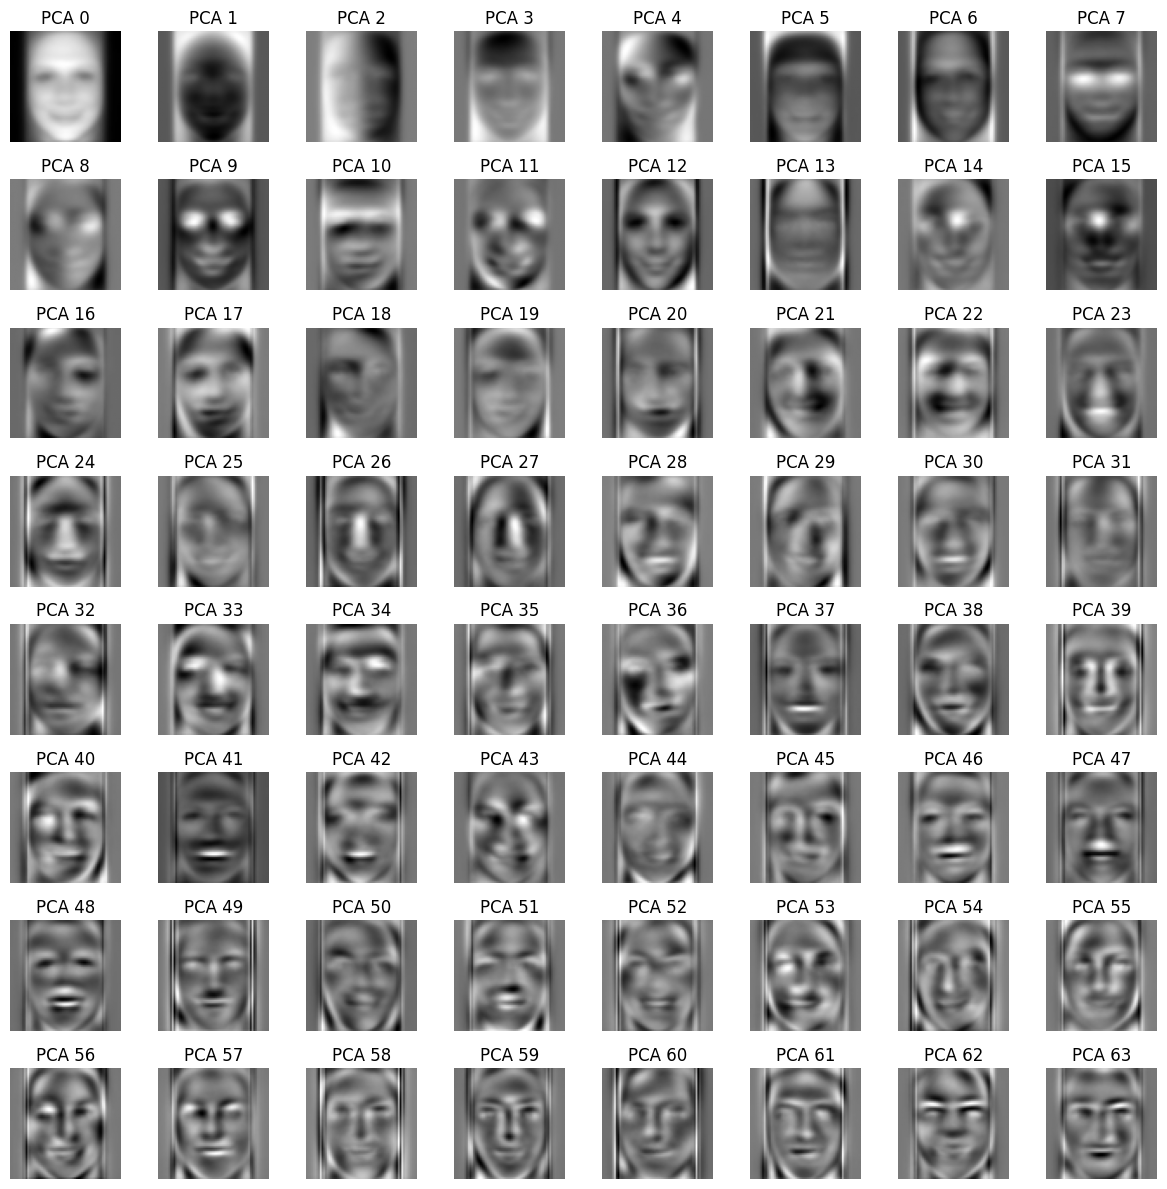

In [30]:
plt.set_cmap('grey')

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    ax = axes[i // 8][i % 8]
    ax.imshow(pca_yolo.components_[i].reshape(64, 64))
    ax.set_title(f'PCA {i}')
    ax.axis(False)

plt.tight_layout()
plt.show()

## MTCNN

In [31]:
data_mtcnn = get_data('dataset2/train', faces_per_class=75)
len(data_mtcnn[1])

75

In [32]:
concatenated_mtcnn = np.concatenate(data_mtcnn, axis=0) / 255
greyscale_mtcnn = np.mean(concatenated_mtcnn, axis=-1)
vector_mtcnn = greyscale_mtcnn.reshape(-1, 64 * 64)

vector_mtcnn.shape

(36000, 4096)

In [33]:
import sklearn
from sklearn.decomposition import PCA

pca_mtcnn = PCA(n_components=128)
pca_mtcnn.fit(vector_mtcnn)

pca_mtcnn.explained_variance_ratio_.sum()

0.8917641239432184

<Figure size 640x480 with 0 Axes>

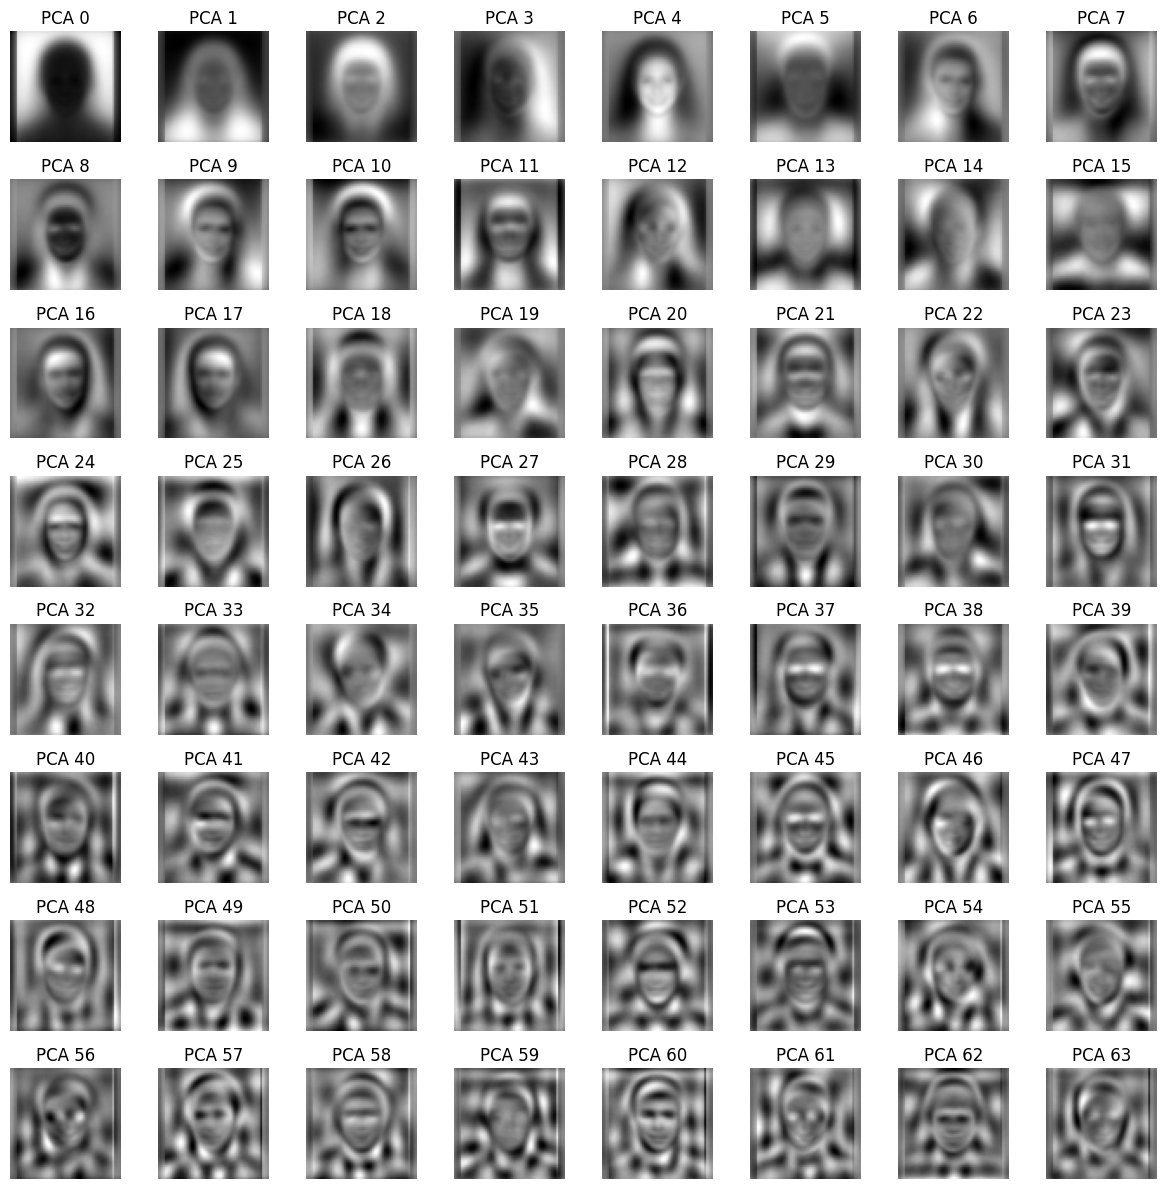

In [34]:
plt.set_cmap('grey')

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    ax = axes[i // 8][i % 8]
    ax.imshow(pca_mtcnn.components_[i].reshape(64, 64))
    ax.set_title(f'PCA {i}')
    ax.axis(False)

plt.tight_layout()
plt.show()

In [35]:
config_data_mtcnn = {
    'img_size': 64,
    'n_components': pca_mtcnn.n_components_,
    'mean': pca_mtcnn.mean_.tolist(),
    'components': pca_mtcnn.components_.tolist(),
    'eigenvalues': pca_mtcnn.explained_variance_.tolist()
}

with open('mtcnn_eigenface.config', 'w') as f:
    json.dump(config_data_mtcnn, f)